# 2D Travel Time Tomography

Seismic travel time tomography is a typical non-linear geophysical inverse problem used to image the Earth's interior. The underground seismic velocity structure is mapped using measured first-arrival travel times of seismic waves traveling between source and receiver locations. In this tutorial, we show how to use GeoPVI package to perform 2D travel time tomography.

As a benchmark example, we will perform all methods supported in GeoPVI, specifically incluidng **ADVI**, **PSVI**, **normalising flows** and **BVI**.

## Import libraries

In [121]:
import numpy as np
import torch
from scipy.stats import norm
import geopvi
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
torch.set_default_dtype(torch.float64)

### Set your own GeoPVI path here

In [35]:
geopvi_path = '/home/GeoPVI/'

## Setup geometry and true velocity model

### Sources and receivers locations

In this example, we mimic a typical inter-receiver interferometry setting where travel times between pairs of receivers are estimated from cross-correlation of ambient seismic noise data.

In [6]:
angle = np.arange(0., 2.*np.pi, np.pi/8)

src = np.array([[4.*np.sin(x), 4.*np.cos(x)] for x in angle])
rec = src

srcx = np.ascontiguousarray(src[:,0])
srcy = np.ascontiguousarray(src[:,1])
recx = np.ascontiguousarray(rec[:,0])
recy = np.ascontiguousarray(rec[:,1])

Define a travel time data mask to denote which travel time data are used for inversion
- mask = 0: this travel time is not used;
- mask = 1: this travel time is used for inversion;

In [8]:
mask = np.zeros((2,len(srcx)*len(srcx)),dtype=np.int32)
for i in range(len(srcx)):
     for j in range(len(srcx)):
            if (j>i):
                mask[0,i*len(srcx)+j] = 1
                mask[1,i*len(srcx)+j] = i*len(srcx) + j + 1

### True velocity model

The true velocity model used in this test is a homogeneous model with a low velocity anomaly located at the center of the model.

The velocity model is defined based on a 101*101 grid system

In [10]:
vel = np.ones(101*101)*2.0
for i in range(101):
    for j in range(101):
        if ((i*0.1 + ymin)**2.0 + (j*0.1 + xmin)**2.0) < 4.0:
            vel[i*101+j]=1.0

vel_true = np.reshape(vel, (101, -1))

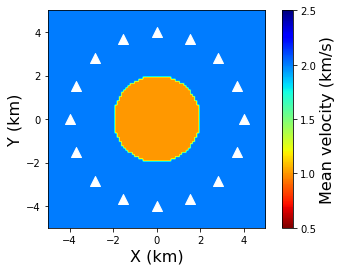

In [11]:
plt.figure()
plt.scatter(srcx, srcy, s= 100, color= 'w' ,marker='^')
plt.imshow(vel_true, cmap='jet_r', clim=(0.5, 2.5), extent=[-5,5,-5,5])
plt.ylabel('Y (km)', fontsize=16)
plt.xlabel('X (km)', fontsize=16)
cbar = plt.colorbar(ticks=[0.5, 1, 1.5, 2, 2.5])
cbar.set_label('Mean velocity (km/s)', fontsize=16)
plt.show()

## Define the forward function and observed data

We use fast marching method (FMM) to peroform forward and gradient calculations given a velocity model sample.

This forward function is provided by GeoPVI. Details can be found in `GeoPVI/forward/tomo2d`. 

The main simulation code is written by Fortran, and we privode a Python wrapper so users can directly call it with Python.

In [12]:
from geopvi.forward.tomo2d.fmm import fm2d

In [48]:
xmin = -5.
ymin = -5.
xman = 5
ymax = 5
dx = 0.5
dy = 0.5
gdx = 5
gdy = 5
sdx = 4
sext = 4

In [19]:
time, _ = fm2d(vel_true.flatten(), srcx, srcy, recx, recy, mask, 101, 101, xmin, ymin, 0.1, 0.1, gdx, gdy, sdx, sext, 0)

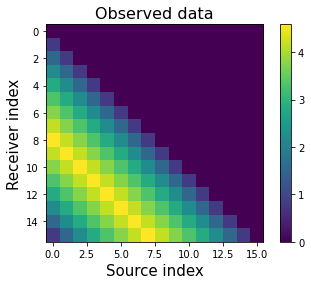

In [29]:
plt.imshow(time.reshape(len(src), -1).T)
plt.xlabel('Source index', fontsize = 15)
plt.ylabel('Receiver index', fontsize = 15)
plt.title('Observed data', fontsize = 16)
plt.colorbar()
plt.show()

## Define model parametrisation, prior and posterior probability distributions

### Model parametrisation

We parametrise the velocity field into 21*21 regular grid cells with a grid size of 0.5 km in both x and y directions.

In [33]:
nx = 21
ny = 21

For each grid cell, we use a Uniform prior pdf bounded by lower (0.5 km/s) and upper (3.0 km/s) bounds.

This can be accomplished using GeoPVI provided prior pdfs in `GeoPVI/prior.py`. 

In [59]:
from geopvi.prior import Uniform

prior = Uniform(lower = np.full((nx*ny,), 0.5), upper = np.full((nx*ny,), 3.0))

### Define the posterior pdf

The posterior pdf corresponding to 2D travel time tomography is provided in GeoPVI at `GeoPVI/forward/tomo2d/posterior.py`

Parameters required by the posterior object:
- data_obs: observed data vector
- config: configure file used to define nuisance parameters for 2D FMM code (an example can be found in `GeoPVI/examples/tomo2d/input`)
- src/rec: source and receiver locations
- sigma: data noise
- mask: a np.ndarray defining which source-receiver travel time data are used for inversion
- num_processes: number of processes used to parallelise forward simulation
- log_prior: a function evaluating logarithmic prior probability values for input samples

In [36]:
import configparser

name = geopvi_path + 'examples/tomo2d/input/config.ini'
config = configparser.ConfigParser()
config._interpolation = configparser.ExtendedInterpolation()
config.read(name)

['/lustre03/other/2029iw/study/00_GeoPVI/examples/tomo2d/input/config.ini']

In [86]:
from geopvi.forward.tomo2d.posterior import Posterior

posterior = Posterior(time, config, src, rec, mask = mask, sigma = 0.05, log_prior = prior.log_prob, num_processes = 10)

## Define variational distribution and perform inversion

In GeoPVI, we provide two different approaches to build a parametric variational distribution, one using a **flows-based model** and the other using **boosting variational inferece**. We will demonstrate how to them separately.

### Inference using flows-based model

### Mean field ADVI

In GeoPVI, ADVI, PSVI and normalising flows are implemented using a flows-based model, where a set of invertible transforms are applied to convert a simple base probability distribution (a Uniform or a standard Normal distribution) into a good approximation to the posterior pdf.

#### 1. Define the transforms (flows) used for inversion

In [64]:
from geopvi.nfvi.flows import Real2Constr, Linear

flows_mf_advi = [Linear(dim = nx * ny, kernel = 'diagonal'), Real2Constr(dim = nx*ny, lower = 0.5, upper = 3.0)]

#### 2. Define a variational distribution using the flows defined above

In [65]:
from geopvi.nfvi.models import FlowsBasedDistribution

variational_mf_advi = FlowsBasedDistribution(flows_mf_advi, base = 'Normal')

#### 3. Setup gradient-based optimisation

This can be done by setting up training process by users or use GeoPVI provided wrapper class to perform inversion

In [66]:
from geopvi.nfvi.models import VariationalInversion

mf_advi = VariationalInversion(variationalDistribution = variational_mf_advi, log_posterior = posterior.log_prob)

#### 4. Perform inversion

Calling VariationalInversion().update() will update variational parameters defined in the flows, and return negative ELBO values (loss) at each iteration.

In [67]:
loss_mf_advi = mf_advi.update(optimizer = 'torch.optim.Adam', lr = 0.0025, n_iter = 5000, nsample = 5, n_out = 5, verbose = True)

----------------------------------------

Iteration:     0,	Loss:    2346.58
The elapsed time is: 0.31 s
Iteration:  1000,	Loss:     331.73
The elapsed time is: 315.01 s
Iteration:  2000,	Loss:     293.62
The elapsed time is: 631.63 s
Iteration:  3000,	Loss:     278.57
The elapsed time is: 943.77 s
Iteration:  4000,	Loss:     300.90
The elapsed time is: 1258.29 s
Iteration:  5000,	Loss:     285.52
The elapsed time is: 1573.50 s
----------------------------------------

Finish training!


### Full rank ADVI

The implementation of full rank ADVI is almost the same as that of mean field ADVI. 

You need to only change the `kernel` option in **Linear** flow from `kernel = 'diagonal'` to `kernel = 'fullrank'`.

In [60]:
flows_fr_advi = [Linear(dim = nx * ny, kernel = 'fullrank'), Real2Constr(dim = nx*ny, lower = 0.5, upper = 3.0)]

In [61]:
variational_fr_advi = FlowsBasedDistribution(flows_fr_advi, base = 'Normal')

In [62]:
fr_advi = VariationalInversion(variationalDistribution = variational_fr_advi, log_posterior = posterior.log_prob)

In [63]:
loss_fr_advi = fr_advi.update(optimizer = 'torch.optim.Adam', lr = 0.0025, n_iter = 5000, nsample = 5, n_out = 5, verbose = True)

----------------------------------------

Iteration:     0,	Loss:    2470.42
The elapsed time is: 0.31 s
Iteration:  1000,	Loss:     263.34
The elapsed time is: 323.02 s
Iteration:  2000,	Loss:     375.65
The elapsed time is: 650.43 s
Iteration:  3000,	Loss:     305.91
The elapsed time is: 974.32 s
Iteration:  4000,	Loss:     288.28
The elapsed time is: 1298.43 s
Iteration:  5000,	Loss:     334.49
The elapsed time is: 1624.61 s
----------------------------------------

Finish training!


### PSVI

To perform PSVI, another mask (not the one defined above for observed data) is required to define a desired local correlation structure by specificing non-zero trainable off-diagonal elements (more details can be found in [Zhao and Curtis, 2024b](https://essopenarchive.org/doi/full/10.22541/essoar.171691139.96106369)).

In [71]:
def get_offdiag_mask(correlation, ndim, nx = 1, ny = 1):
    y, x = correlation.shape
    rank = (correlation != 0).sum() // 2
    cy, cx = (correlation.size)//2 // x, (correlation.size)//2 % x
    offset = np.zeros(rank, dtype = int)
    mask = np.ones((rank, ndim), dtype = bool)
    i = 0
    for iy in range(y):
        for ix in range(x):
            if correlation[iy, ix] == 0 or iy * x + ix >= (correlation.size)//2:
                continue
            offset[i] = (cy - iy) * nx + (cx - ix)
            mask[i, -offset[i]:] = False
            i += 1
    return mask

In [72]:
cov_template = np.ones([10, 10])
off_diag_mask = get_offdiag_mask(cov_template, nx * ny, nx = nx, ny = ny)

In [73]:
flows_psvi = [Linear(dim = nx * ny, kernel = 'structured', mask = off_diag_mask), Real2Constr(dim = nx*ny, lower = 0.5, upper = 3.0)]

In [74]:
variational_psvi = FlowsBasedDistribution(flows_psvi, base = 'Normal')

In [75]:
psvi = VariationalInversion(variationalDistribution = variational_psvi, log_posterior = posterior.log_prob)

In [77]:
loss_psvi = psvi.update(optimizer = 'torch.optim.Adam', lr = 0.0025, n_iter = 5000, nsample = 5, n_out = 5, verbose = True)

----------------------------------------

Iteration:     0,	Loss:    2186.65
The elapsed time is: 0.35 s
Iteration:  1000,	Loss:     232.58
The elapsed time is: 326.06 s
Iteration:  2000,	Loss:     209.06
The elapsed time is: 649.90 s
Iteration:  3000,	Loss:     204.99
The elapsed time is: 976.00 s
Iteration:  4000,	Loss:     217.92
The elapsed time is: 1302.55 s
Iteration:  5000,	Loss:     201.70
The elapsed time is: 1628.47 s
----------------------------------------

Finish training!


### Normalising flows

For normalising flows, we need to define a set of invertible transforms (flows), similarly to the above **Linear** transform.

In GeoPVI, we provide several commonly used flows that has been tested to be effective -- details can be found in `GeoPVI/nfvi/flows.py`. If you tested some flows to be effective for geophysical inverse problems, please do consider raising a PR.

In this test, we use the neural spline flows proposed in [Durkan et al., 2019](https://arxiv.org/abs/1906.04032).

### 1. Import flows

In [78]:
from geopvi.nfvi.flows import NSF_CL, Permute

We use 6 **NSF** flows with **coupling layers**. For each flow, we set `k=8` and `B=3`, and use a fully connected neural network with 2 hidden layers (each contianing 64 and 128 neurons) to learn hyper-parameters for the spline function ([Durkan et al., 2019](https://arxiv.org/abs/1906.04032)). After each NSF flow, we add another **Permute** flow to randomly permute model vectors, to better model inter-parameter correlations.

In [150]:
flows_nf = []

for _ in range(6):
    flows_nf += [NSF_CL(dim = nx * ny, K = 8, B = 3, hidden_dim = [64, 128]), Permute(dim = nx * ny)]
flows_nf += [Real2Constr(dim = nx*ny, lower = 0.5, upper = 3.0)]

In [151]:
variational_nf = FlowsBasedDistribution(flows_nf, base = 'Uniform')

The number of trainable parameters is

In [152]:
sum(p.numel() for p in variational_nf.parameters())

8120634

In [154]:
nf = VariationalInversion(variationalDistribution = variational_nf, log_posterior = posterior.log_prob)
loss_nf = nf.update(optimizer = 'torch.optim.Adam', lr = 0.0025, n_iter = 3000, nsample = 10)

### Inference using boosting variational inference (BVI)

We consider using a diagonal Gaussian distribution as component distribution, therfore the posterior pdf is a mixture of Gaussian distributions.

More implementation details can be found in `01_toy_example` tutorial.

In [96]:
from geopvi.boostingvi.component import GaussianComponent

Here, the Gaussian distribution is defined in a constrained space bounded by `lower` and `upper` values, which is accomplished by transforming the unconstrained Gaussian distribution by the `Real2Constr` flow used above.

In [157]:
component = GaussianComponent(dim = nx * ny, perturb = 0.5, constrained = True, lower = 0.5, upper = 3.0, base = 'Uniform')

Define a mixture of Gaussian components using `BoostingGaussian`.

In [158]:
from geopvi.boostingvi.bvi import BoostingGaussian

bvi = BoostingGaussian(componentDistribution = component, log_posterior = posterior.log_prob, lmb=lambda x: 1./(x+1)**0.2, weight_init='equal')

Optimise each Gaussian component sequentially.

In [160]:
bvi_results = bvi.update(ncomponent = 10, n_iter = 2500, lr = 0.0025, nsample = 5)

## Retrive the results

Both flows-based and BVI-based methods provide a sample function so samples from the obtained variational distribution (an approximate to the posterior distribution) can be obtained directly by calling the function.

In [148]:
samples_mfadvi = variational_mf_advi.sample(2000)
samples_psvi = variational_psvi.sample(2000)
samples_fradvi = variational_fr_advi.sample(2000)
samples_nf = variational_nf.sample(2000)
samples_bvi = bvi.sample(5000)

Alternatively, the obtained parametric variational pdf can be reconstrcuted using optimised variational parameteres. Below we show an example using results from full-rank ADVI. Reconstruction examples using mean field ADVI and PSVI can be found in `31_2D_FWI` tutorial.

#### 1. Retrive mean vector (mus), standard deviation vector (sigmas), and non-diagonal elements (non_diag) from the flows-based model

In [109]:
mus = variational_fr_advi.flows[-2].u.detach().numpy()
sigmas = np.exp(variational_fr_advi.flows[-2].diag.detach().numpy())
non_diag = variational_fr_advi.flows[-2].non_diag.detach().numpy()

#### 2. Create the lower-triangular matrix $\mathbf{L}$

In [112]:
def create_lower_triangular(sigmas, off_diagonals):
    ndim = len(sigmas)
    lower = np.zeros((ndim, ndim))
    lower[np.tril_indices(ndim, -1)] = off_diagonals
    return lower + np.diag(sigmas)

In [113]:
L = create_lower_triangular(sigmas, non_diag)

#### 3. Sample from the Gaussian distribution ,and transform samples to constrained space

In [114]:
def real_2_cons(x, lower, upper):
    z = lower + (upper - lower) / (1 + np.exp(-x))
    return z

In [118]:
eplisons = np.random.normal(0, 1, size = (2000, nx*ny))
theta = mus + (L @ eplisons.T).T

samples_fradvi = real_2_cons(theta, 0.5, 3.0)

## Plot results

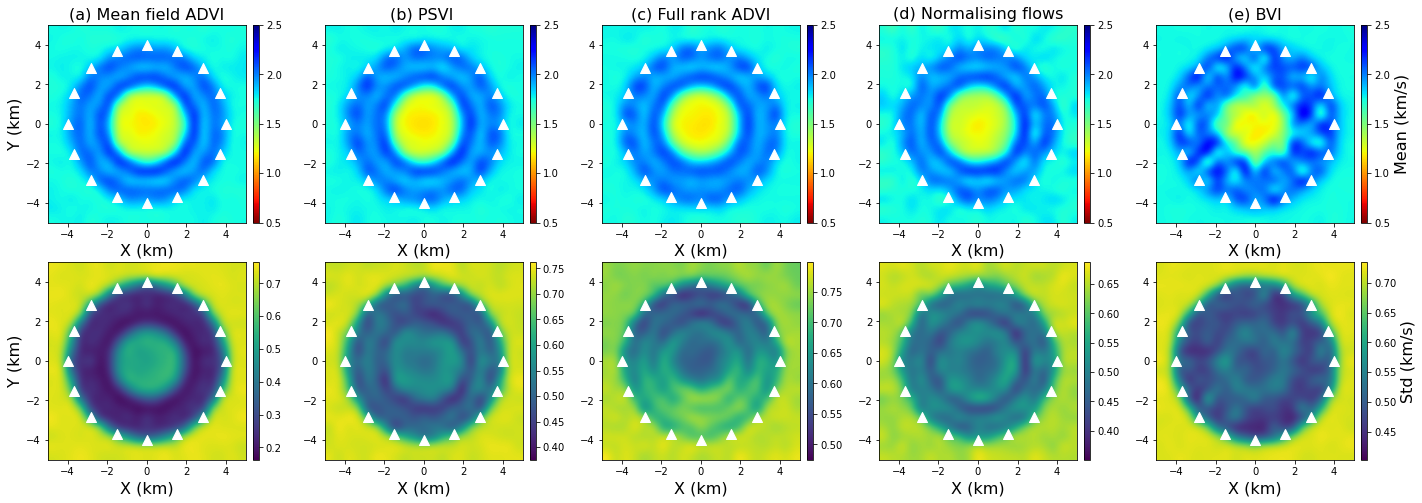

In [156]:
nrow = 2
ncol = 5

samples = [samples_mfadvi, samples_psvi, samples_fradvi, samples_nf, samples_bvi]
title = ['(a) Mean field ADVI', '(b) PSVI ', '(c) Full rank ADVI', '(d) Normalising flows', '(e) BVI']

fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = (24, 8))

for j in range(ncol):
    mean = samples[j].mean(axis = 0)
    std = samples[j].std(axis = 0)
    
    ax[0, j].scatter(srcx, srcy, s= 100, color= 'w' ,marker='^')
    im = ax[0, j].imshow(mean.reshape(21, -1), cmap='jet_r', interpolation = 'bicubic', clim=(0.5, 2.5), extent=[-5.,5.,-5.,5.])
    if j == 0:
        ax[0, j].set_ylabel('Y (km)', fontsize=16)
    ax[0, j].set_xlabel('X (km)', fontsize=16)
    ax[0, j].set_title(title[j], fontsize = 16)
    divider = make_axes_locatable(ax[0,j])
    cax = divider.append_axes("right",size="3%",pad=0.1)
    cbar = plt.colorbar(im, cax = cax, ticks=[0.5, 1, 1.5, 2, 2.5])
    if j == ncol - 1:
        cbar.set_label('Mean (km/s)', fontsize=16)
    
    
    ax[1, j].scatter(srcx, srcy, s= 100, color= 'w' ,marker='^')
    im = ax[1, j].imshow(std.reshape(21, -1), interpolation = 'bicubic', extent=[-5.,5.,-5.,5.])
    if j == 0:
        ax[1, j].set_ylabel('Y (km)', fontsize=16)
    ax[1, j].set_xlabel('X (km)', fontsize=16)
    divider = make_axes_locatable(ax[1,j])
    cax = divider.append_axes("right",size="3%",pad=0.1)
    cbar = plt.colorbar(im, cax = cax)
    if j == ncol - 1:
        cbar.set_label('Std (km/s)', fontsize=16)
        
plt.show()

## References

1. Xuebin Zhao, Andrew Curtis and Xin Zhang, 2021. Bayesian Seismic Tomography using Normalising Flows. Geophys. J. Int.
2. Xuebin Zhao and Andrew Curtis, 2024a. Bayesian Inversion, Uncertainty Analysis and Interrogation using Boosting Variational Inference. J. Geophys. Res. Solid Earth.
3. Xuebin Zhao and Andrew Curtis, 2024b. Physically Structured Variational Inference for Bayesian Full Waveform Inversion. ESS Open archive.